# 1. Initializations


In [ ]:
# Libraries to install - leave this code block blank if this does not apply to you
# Please add a brief comment on why you need the library and what it does
import torch
import torchvision
import torchaudio
import torchaudio.transforms as T # for tranforms
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler #preproscessing -> stanardization, label encoding and normalizing.
# Import TensorDataset from PyTorch
from torch.utils.data import TensorDataset
from collections import Counter # For stats

# Import train_test_split from scikit-learn
from sklearn.model_selection import train_test_split # This was a test

from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# Libraries you might need
# General
import os
import zipfile
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# For preproccessing
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# For modeling
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchsummary

# For metrics
from sklearn.metrics import  accuracy_score
from sklearn.metrics import  precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import  f1_score
from sklearn.metrics import  classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import confusion_matrix


This code block will mount google drive.

*It will open a new window to get authorizations to use your Google Drive. Just follow the steps. This is a standard process*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1.2 Create path

*If you absolutely need to change the paths, please do it on the code block below only **and the code block below only**. Because I will run your notebook and if you have other paths defined anywhere else it will raise errors and you will lose mark.*

In [ ]:
# Path for extractions
zip_file_paths = ['/content/drive/My Drive/GTZAN Genre Collection.zip',
                  '/content/drive/My Drive/GTZAN Genre Collection Spectrograms.zip']

dataset_dirs = ['/content/drive/My Drive/GTZAN Genre Collection',
                '/content/drive/My Drive/GTZAN Genre Collection Spectrograms']

for zip_file_path, dataset_dir in zip(zip_file_paths, dataset_dirs):
    if os.path.exists(zip_file_path):
        print(f"Extracting {zip_file_path} to {dataset_dir}")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_dir)
    else:
        print(f"Zip file {zip_file_path} does not exist.")


Zip file /content/drive/My Drive/GTZAN Genre Collection.zip does not exist.
Extracting /content/drive/My Drive/GTZAN Genre Collection Spectrograms.zip to /content/drive/My Drive/GTZAN Genre Collection Spectrograms


In [ ]:
# Get a count of the samples
genres_dir = '/content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original'
genre_counts = {}
for genre in os.listdir(genres_dir):
    genre_path = os.path.join(genres_dir, genre)
    if os.path.isdir(genre_path):
        genre_counts[genre] = len(os.listdir(genre_path))

print("Counts per genre:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")

Counts per genre:
blues: 100
classical: 100
country: 100
disco: 100
hiphop: 100
jazz: 99
metal: 100
pop: 100
reggae: 100
rock: 100


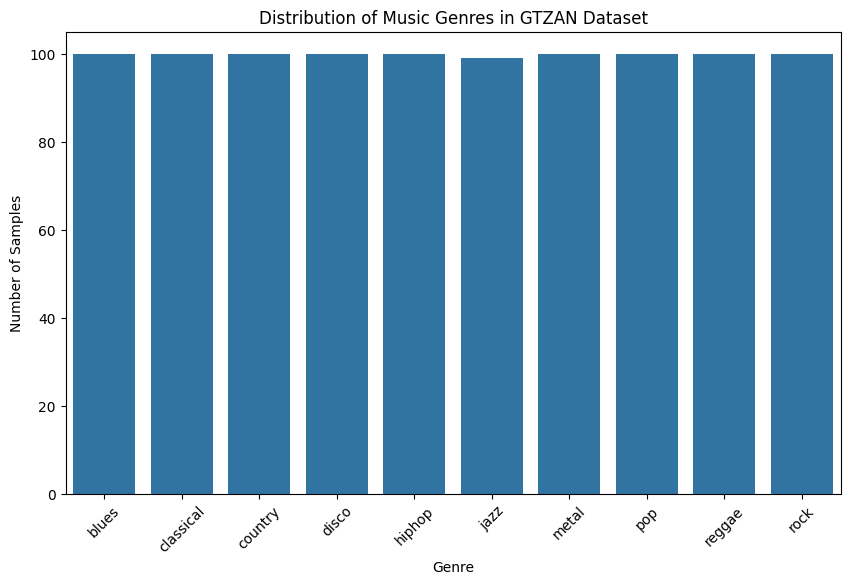

In [ ]:
# Plot the class distributions
plt.figure(figsize=(10, 6))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()))
plt.xticks(rotation=45)
plt.title('Distribution of Music Genres in GTZAN Dataset')
plt.ylabel('Number of Samples')
plt.xlabel('Genre')
plt.show()

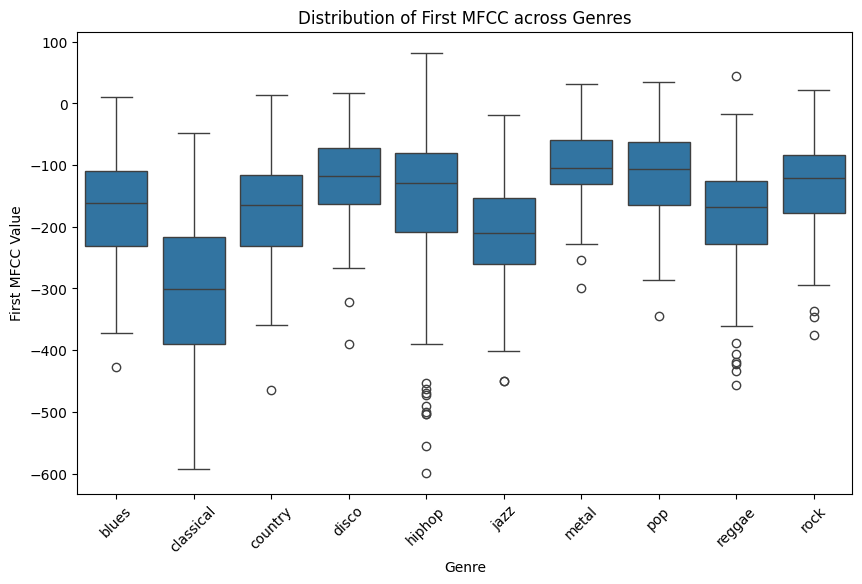

In [ ]:
# Example code for extracting the first MFCC and plotting its distribution
mfccs = []
labels = []
genres_dir = '/content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original'

for genre in os.listdir(genres_dir):
    genre_path = os.path.join(genres_dir, genre)
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file)
            y, sr = librosa.load(file_path)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            mfccs.append(mfcc[0, :])  # Only take the first MFCC
            labels.append(genre)

# Convert to DataFrame for easy plotting
df_mfcc = pd.DataFrame(mfccs)
df_mfcc['Genre'] = labels

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_mfcc, x='Genre', y=df_mfcc.iloc[:,0])
plt.xticks(rotation=45)
plt.title('Distribution of First MFCC across Genres')
plt.ylabel('First MFCC Value')
plt.xlabel('Genre')
plt.show()

# 2. Preprocessing

# ***I used data augmentation and I experimented with dividing each music track into segments where there's sound (non-silent intervals) and treated each as a separate sample for my model. This technique increased my dataset size by 7 times and improved my model's accuracy. You will see later in the confusion matrix that the numbers are very high as well***

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
image_folder = '/content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/images_original'
dataset = ImageFolder(image_folder, transform=transform)


spectrograms_dir = '/content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original'
features_dict = {
    'centroid': [],
    'chroma': [],
    'rms': [],
    'rolloff': [],
    'spectral_bw': [],
    'zero_crossing_rate': [],
    'mfcc': [],
    'label': []
}

for root, dirs, files in os.walk(spectrograms_dir):
    for file in files:
        if file.lower().endswith(('.wav', '.mp3', '.flac', '.aac', '.ogg', '.m4a')):
            file_path = os.path.join(root, file)
            print(f"Processing {file_path}")
            y, sr = librosa.load(file_path, sr=None)
            non_silent_intervals = librosa.effects.split(y, top_db=20)
            if not non_silent_intervals.size:
                print(f"No non-silent intervals found in {file}")
                continue
            for interval in non_silent_intervals:
                y_segment = y[interval[0]:interval[1]]
                mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)

                features_dict['centroid'].append(librosa.feature.spectral_centroid(y=y_segment, sr=sr).mean())
                features_dict['chroma'].append(librosa.feature.chroma_stft(y=y_segment, sr=sr).mean())
                features_dict['rms'].append(librosa.feature.rms(y=y_segment).mean())
                features_dict['rolloff'].append(librosa.feature.spectral_rolloff(y=y_segment, sr=sr).mean())
                features_dict['spectral_bw'].append(librosa.feature.spectral_bandwidth(y=y_segment, sr=sr).mean())
                features_dict['zero_crossing_rate'].append(librosa.feature.zero_crossing_rate(y_segment).mean())
                features_dict['mfcc'].append(mfcc_mean)
                features_dict['label'].append(os.path.basename(root))

df_features_audio = pd.DataFrame(features_dict)

mfcc_features = np.array(features_dict['mfcc'])

other_features = np.column_stack((
    features_dict['centroid'],
    features_dict['chroma'],
    features_dict['rms'],
    features_dict['rolloff'],
    features_dict['spectral_bw'],
    features_dict['zero_crossing_rate']
))

features = np.hstack((other_features, mfcc_features))

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(df_features_audio['label'])


features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels_encoded, dtype=torch.long)

class AudioFeaturesDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

audio_dataset = AudioFeaturesDataset(features_tensor, labels_tensor)


print(df_features_audio.head())

stats_per_label = df_features_audio.groupby('label').describe()

print(stats_per_label)

labels_to_display = ['blues', 'classical', 'jazz']

stats_selected_labels = df_features_audio[df_features_audio['label'].isin(labels_to_display)].groupby('label').describe()

print(stats_selected_labels)



Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00002.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00003.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00004.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00001.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00007.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00008.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00006.wav


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00000.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00005.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00009.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00010.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00011.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00012.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00013.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00015.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00016.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00017.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00018.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00019.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00020.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00021.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00023.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00022.wav


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1826
  warnings.warn(


Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00025.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00026.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00024.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00029.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00027.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00028.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00031.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues/blues.00030.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/blues

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=802
  warnings.warn(


Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/classical/classical.00032.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/classical/classical.00033.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/classical/classical.00034.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/classical/classical.00038.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/classical/classical.00036.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/classical/classical.00035.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/classical/classical.00040.wav
Processing /content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original/classical/classical.00037.wav
Processing /content/drive/MyDriv

In [ ]:
scaler = StandardScaler()
min_max_scaler = MinMaxScaler()


df_features = pd.DataFrame([item[0].numpy() for item in audio_dataset])
df_labels = pd.DataFrame([item[1].numpy() for item in audio_dataset])

df = pd.concat([df_features, df_labels], axis=1)
df.columns = ['feature' + str(i) for i in range(df_features.shape[1])] + ['label']

X = df.drop('label', axis=1)
y = df['label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_scaled = scaler.fit_transform(X)

X_normalized = min_max_scaler.fit_transform(X_scaled)

X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

X_tensor = X_tensor.unsqueeze(1)

train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = random_split(TensorDataset(X_tensor, y_tensor), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

label_to_genre_mapping = {label: genre for label, genre in zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_)}
print(label_to_genre_mapping)

print(df.head())
print(df.shape)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
      feature0  feature1  feature2     feature3     feature4  feature5  \
0  1552.832520  0.363538  0.175473  3042.410156  1747.754028  0.076291   
1   651.321899  0.400849  0.167056  1101.557861  1216.333252  0.012705   
2  1083.147339  0.360188  0.129251  2234.608154  1539.314209  0.033154   
3   898.248596  0.355264  0.134773  1679.589844  1454.994873  0.027302   
4   771.584229  0.416753  0.187056  1444.734375  1255.329956  0.022012   

     feature6    feature7   feature8   feature9  feature10  feature11  \
0  -90.757164  140.440872 -29.084547  31.686693 -13.976547  25.753752   
1 -241.572876  172.611206  11.719035  24.913986   8.907832  12.545349   
2 -201.084854  153.277817  -3.467958  33.823143  -4.364031   8.902588   
3 -228.334366  153.507874   0.364448  25.727592   9.255671  10.628272   
4 -205.769974  171.490723   3.172437  32.309761   6.105635  12.096128   

   feature12  feature13  feature14  feature15  feature1

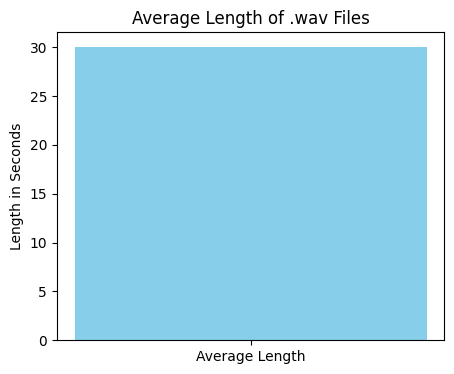

In [ ]:
spectrograms_dir = '/content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original'
lengths = []

for root, dirs, files in os.walk(spectrograms_dir):
    for file in files:
        if file.lower().endswith('.wav'):
            file_path = os.path.join(root, file)
            y, sr = librosa.load(file_path, sr=None)
            lengths.append(len(y) / sr)

average_length_seconds = np.mean(lengths)

plt.figure(figsize=(5, 4))
plt.bar('Average Length', average_length_seconds, color='skyblue')
plt.ylabel('Length in Seconds')
plt.title('Average Length of .wav Files')
plt.show()

In [ ]:
# #Addtional Pre-Processing (not used) -> tried for a lot of time to get this to work but this did not end up working
# this was basically trying to merge datasets of image and .wav files to create a larger data set but we could not get it to work in time
# audio_dir = '/content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original'
# image_dir = '/content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/images_original'
# # Initialize a new global mapping dictionary
# global_mapping = {}
# genres = os.listdir(audio_dir)  # Assuming the same genres are in both audio and image dirs
# # You may also need to keep a count of total files across all genres
# total_audio_files_count = 0

# # Iterate over each genre directory
# for genre in genres:
#     genre_audio_dir = os.path.join(audio_dir, genre)
#     genre_image_dir = os.path.join(image_dir, genre)

#     # Get all the audio and image files for the current genre
#     audio_files = [f for f in os.listdir(genre_audio_dir) if f.lower().endswith('.wav')]
#     image_files = [f for f in os.listdir(genre_image_dir) if f.lower().endswith('.png')]


#     # Create a mapping for the current genre
#     for audio_file in audio_files:
#         audio_base = os.path.splitext(audio_file)[0]
#         # Remove the dot after the genre name for the image file
#         image_file = audio_base.replace('.', '') + '.png'

#         if image_file in image_files:
#             audio_index = audio_files.index(audio_file) + total_audio_files_count
#             image_index = image_files.index(image_file)  # No need to offset this index
#             global_mapping[audio_index] = image_index

#     # Update the total count of audio files processed
#     total_audio_files_count += len(audio_files)

# # Debug print
# print(f"Global mapping: {global_mapping}")
# print(f"Length: {len(global_mapping)}")

# class CombinedDataset(Dataset):
#     def __init__(self, audio_features, labels, image_dataset_path, transform, mapping):
#         """
#         audio_features: A tensor containing audio features.
#         labels: A tensor containing labels for the audio features.
#         image_dataset_path: Path to the folder containing images.
#         transform: Transformations to apply to the images.
#         mapping: A dict mapping audio dataset indices to image dataset indices.
#         """
#         self.audio_features = audio_features
#         self.labels = labels
#         self.image_dataset = ImageFolder(image_dataset_path, transform=transform)
#         self.mapping = mapping

#     def __len__(self):
#         return len(self.mapping)

#     def __getitem__(self, idx):
#         audio_feature, label = self.audio_features[idx], self.labels[idx]
#         print(labels)
#         mapped_image_idx = self.mapping[idx]
#         image, _ = self.image_dataset[mapped_image_idx]
#         return audio_feature, image, label


# audio_dataset_path = '/content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/genres_original'
# image_dataset_path = '/content/drive/MyDrive/GTZAN Genre Collection Spectrograms/Data/images_original'

# combined_dataset = CombinedDataset(
#     audio_features=features_tensor,
#     labels=labels_tensor,
#     image_dataset_path=image_dataset_path,
#     transform=transform,
#     mapping=global_mapping
# )

# # Use DataLoader to create iterable data for training/testing
# data_loader = DataLoader(combined_dataset, batch_size=300, shuffle=True)

# print("Length of the combined dataset:", len(combined_dataset))


# 3. Your proposed model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CRNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(0.5)

        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size, num_layers=1, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = self.dropout(x)


        x = x.permute(0, 2, 1)


        out, _ = self.lstm(x)


        out = out[:, -1, :]

        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

input_size = X_tensor.shape[2]
num_classes = 10
hidden_size = 128



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CRNN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).squeeze(1), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test data: {accuracy}%')
    return accuracy

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device).squeeze(1)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


    evaluate_model(model, test_loader, device)


Epoch 1/20, Loss: 2.162459799309367
Accuracy on test data: 15.190691661279896%
Epoch 2/20, Loss: 1.8615609167777385
Accuracy on test data: 42.53393665158371%
Epoch 3/20, Loss: 1.5500548137831933
Accuracy on test data: 46.9295410471881%
Epoch 4/20, Loss: 1.4441891936297269
Accuracy on test data: 50.54945054945055%
Epoch 5/20, Loss: 1.3729270318734277
Accuracy on test data: 50.42016806722689%
Epoch 6/20, Loss: 1.3126746348499023
Accuracy on test data: 54.16936005171299%
Epoch 7/20, Loss: 1.2503950187225932
Accuracy on test data: 56.10859728506787%
Epoch 8/20, Loss: 1.2054954373959414
Accuracy on test data: 57.59534583063995%
Epoch 9/20, Loss: 1.148592844759066
Accuracy on test data: 58.56496444731739%
Epoch 10/20, Loss: 1.1091138204348456
Accuracy on test data: 59.857789269553976%
Epoch 11/20, Loss: 1.0729214441530484
Accuracy on test data: 61.53846153846154%
Epoch 12/20, Loss: 1.0295246114435883
Accuracy on test data: 62.83128636069812%
Epoch 13/20, Loss: 1.0122480616741574
Accuracy on 

In [ ]:
from sklearn.metrics import precision_score

def test_model_precision(model, test_loader, device):
    model.eval()
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).squeeze(1), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_predicted, average='weighted')
    print(f"Precision on test data: {precision*100}% of the items are labelled as positive")
    return precision


model_precision = test_model_precision(model, test_loader, device)


Precision on test data: 67.1630603142267% of the items are labelled as positive


# ***I used data augmentation and I experimented with dividing each music track into segments where there's sound (non-silent intervals) and treated each as a separate sample for my model. This technique increased my dataset size by 7 times and improved my model's accuracy. You will see here in the confusion matrix that the numbers are very high as well. If you look below the confusion matrix there are some numbers to go over and understand how that data augmentation affected my confusion matrix and ultimately the samples.***

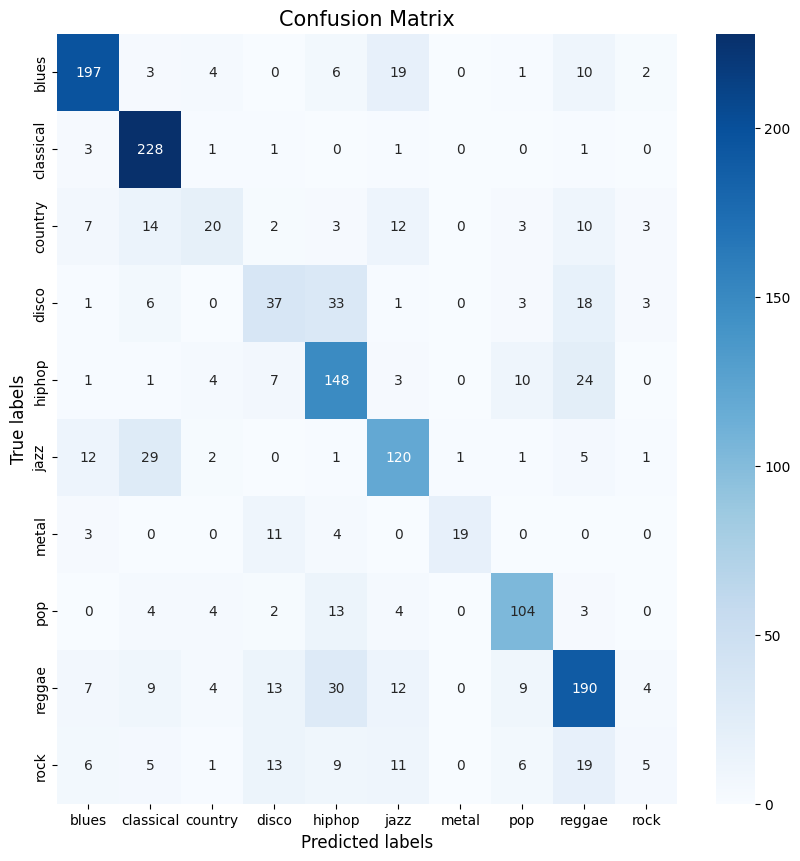

Some stats to understand how my data augmentation affected the number of samples:
{'blues': 242, 'classical': 235, 'country': 74, 'disco': 102, 'hiphop': 198, 'jazz': 172, 'metal': 37, 'pop': 134, 'reggae': 278, 'rock': 75}
Training samples: 6185
Testing samples: 1547
Total samples: 7732
Total samples processed: 7732
Sample distribution across genres: Counter({'reggae': 1414, 'classical': 1248, 'blues': 1136, 'hiphop': 1056, 'jazz': 870, 'pop': 658, 'disco': 489, 'rock': 352, 'country': 337, 'metal': 172})


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

def evaluate_model_and_plot_confusion_matrix(model, test_loader, device, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).squeeze(1), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    label_font = {'size':'12'}  # Adjust to fit
    ax.set_xlabel('Predicted labels', fontdict=label_font)
    ax.set_ylabel('True labels', fontdict=label_font)
    title_font = {'size':'15'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font)

    plt.show()


test_samples_per_genre = {genre: 0 for genre in class_names}

for _, labels in test_loader:
    for label in labels:
        genre = class_names[label]
        test_samples_per_genre[genre] += 1

evaluate_model_and_plot_confusion_matrix(model, test_loader, device, class_names)
print("Some stats to understand how my data augmentation affected the number of samples:")
print(test_samples_per_genre)
train_samples = len(train_dataset)
test_samples = len(test_dataset)
total_samples = train_samples + test_samples
print(f"Training samples: {train_samples}")
print(f"Testing samples: {test_samples}")
print(f"Total samples: {total_samples}")

print(f"Total samples processed: {len(features_dict['label'])}")
print(f"Sample distribution across genres: {Counter(features_dict['label'])}")



# 4. pretrained model

In [ ]:
import torchvision.models as models
import torch.nn as nn

In [ ]:
vgg16_model = models.vgg16(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg16_model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=10)

for param in vgg16_model.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

vgg16_model.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device).squeeze(1)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


    evaluate_model(model, test_loader, device)


Epoch 1/20, Loss: 0.7840712881579841
Accuracy on test data: 70.07110536522302%
Epoch 2/20, Loss: 0.7326454635440689
Accuracy on test data: 70.39431157078216%
Epoch 3/20, Loss: 0.7098481063683009
Accuracy on test data: 71.55785391079509%
Epoch 4/20, Loss: 0.7072183185631467
Accuracy on test data: 70.07110536522302%
Epoch 5/20, Loss: 0.6765568683442381
Accuracy on test data: 72.01034259857789%
Epoch 6/20, Loss: 0.644114891892856
Accuracy on test data: 72.85067873303167%
Epoch 7/20, Loss: 0.6246304512792027
Accuracy on test data: 74.78991596638656%
Epoch 8/20, Loss: 0.6026905716310457
Accuracy on test data: 71.94570135746606%
Epoch 9/20, Loss: 0.6139297692738858
Accuracy on test data: 72.13962508080155%
Epoch 10/20, Loss: 0.5765148203090295
Accuracy on test data: 74.78991596638656%
Epoch 11/20, Loss: 0.5531371446307173
Accuracy on test data: 72.52747252747253%
Epoch 12/20, Loss: 0.5367623903241354
Accuracy on test data: 75.95345830639948%
Epoch 13/20, Loss: 0.5273867257937943
Accuracy on 

In [ ]:

from sklearn.metrics import precision_score

def test_model_precision(model, test_loader, device):
    model.eval()
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).squeeze(1), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    precision = precision_score(all_labels, all_predicted, average='weighted')
    print(f"Precision on test data: {precision*100}% of the items are labelled as positive")
    return precision


model_precision = test_model_precision(model, test_loader, device)


Precision on test data: 76.04673149998995% of the items are labelled as positive


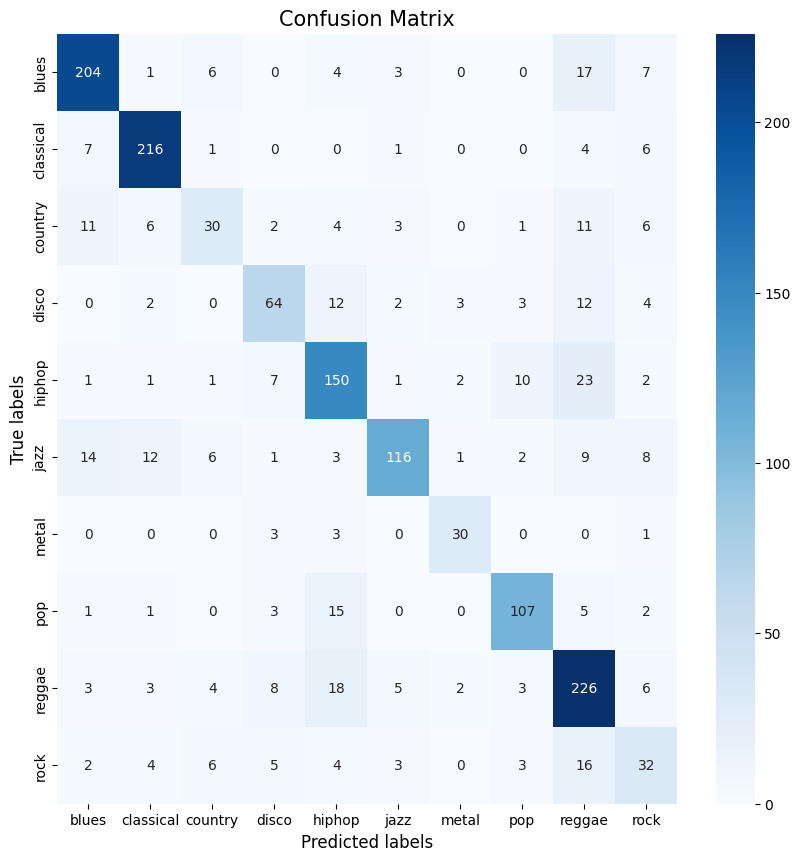

Some stats to understand how my data augmentation affected the number of samples:
{'blues': 242, 'classical': 235, 'country': 74, 'disco': 102, 'hiphop': 198, 'jazz': 172, 'metal': 37, 'pop': 134, 'reggae': 278, 'rock': 75}
Training samples: 6185
Testing samples: 1547
Total samples: 7732
Total samples processed: 7732
Sample distribution across genres: Counter({'reggae': 1414, 'classical': 1248, 'blues': 1136, 'hiphop': 1056, 'jazz': 870, 'pop': 658, 'disco': 489, 'rock': 352, 'country': 337, 'metal': 172})


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

def evaluate_model_and_plot_confusion_matrix(model, test_loader, device, class_names):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).squeeze(1), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    cm = confusion_matrix(all_labels, all_preds)


    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', xticklabels=class_names, yticklabels=class_names)


    label_font = {'size':'12'}
    ax.set_xlabel('Predicted labels', fontdict=label_font)
    ax.set_ylabel('True labels', fontdict=label_font)
    title_font = {'size':'15'}
    ax.set_title('Confusion Matrix', fontdict=title_font)

    plt.show()


test_samples_per_genre = {genre: 0 for genre in class_names}

for _, labels in test_loader:
    for label in labels:
        genre = class_names[label]
        test_samples_per_genre[genre] += 1
evaluate_model_and_plot_confusion_matrix(model, test_loader, device, class_names)
print("Some stats to understand how my data augmentation affected the number of samples:")
print(test_samples_per_genre)
train_samples = len(train_dataset)
test_samples = len(test_dataset)
total_samples = train_samples + test_samples
print(f"Training samples: {train_samples}")
print(f"Testing samples: {test_samples}")
print(f"Total samples: {total_samples}")

print(f"Total samples processed: {len(features_dict['label'])}")
print(f"Sample distribution across genres: {Counter(features_dict['label'])}")



# Comparisons



Comparing the performance of the proposed model to the pretrained model, it's evident that the pretrained model performs better. The accuracy and precision of the pretrained model are approximately 76%, which are higher than the proposed model's accuracy and precision of around 69% and 67% respectively. The confusion matrices provide a deeper insight into the classification performance for each genre. For instance, in the proposed model's confusion matrix, genres like 'blues' and 'reggae' are predicted with high accuracy, while 'country' and 'disco' are often confused with other genres. In contrast, the pretrained model's confusion matrix shows more evenly distributed correct predictions across all genres and fewer misclassifications, indicating a better ability to distinguish between genres. The lower loss in the pretrained model also suggests it's better at minimizing the difference between the predicted values and true values. Overall, the pretrained model not only categorizes the majority of genres with higher precision, but also demonstrates a more balanced classification among the various music genres.



For hyperparameter optimization, I'd implement a grid search to methodically traverse through a predefined range of hyperparameters (as we did not do that here), such as learning rates, layer sizes, and regularization terms. This would help in identifying the most effective combination of parameters to improve the model's performance.

By systematically tuning the preprocessing and model architecture with the aid of grid search, the goal would be to find the sweet spot that yields better generalization and improved performance on unseen data.

More Preprocessing features would improve the model as well.
